### Neural Collaborative Filtering (NCF)
The goal is to create a NCF deep learning model that will provide the user movie recamendations based off of the users reviews as well as similar movies to create detailed movie recamendations. First step is to import in the data and dependencies.
This work is using the example movie recamendation software provided in the Keras documentation here: https://keras.io/examples/structured_data/collaborative_filtering_movielens/ by Siddhartha Banerjee

In [27]:
# Import dependencies
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import inspect
import config
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [28]:
protocol = 'postgresql'
username = config.Username
password = config.Password
host = 'localhost'
port = 5432
database_name = 'movies_db'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
insp = inspect(engine)

In [29]:
sql_join = r"""SELECT movies.movie_id, movies.title, movies.genres, ratings.user_id, ratings.rating, ratings.timestamps
FROM movies
INNER JOIN ratings
ON movies.movie_id=ratings.movie_id;"""
joined_movies_df=pd.read_sql_query(sql_join, con=engine)

In [30]:
#Now we have ported in the all the data from our SQL lets visualise it
joined_movies_df

,movie_id,title,genres,user_id,rating,timestamps
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247
2,6,Heat (1995),Action|Crime|Thriller,1,4.0,964982224
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1,5.0,964983815
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1,5.0,964982931
...,...,...,...,...,...,...
100831,166534,Split (2017),Drama|Horror|Thriller,610,4.0,1493848402
100832,168248,John Wick: Chapter Two (2017),Action|Crime|Thriller,610,5.0,1493850091
100833,168250,Get Out (2017),Horror,610,5.0,1494273047
100834,168252,Logan (2017),Action|Sci-Fi,610,5.0,1493846352


In [31]:
#Not all of that data is needed yet, but will be later in the process. We only need the users feedback data
user_df = joined_movies_df[['user_id','movie_id','rating', 'timestamps']]
user_df

,user_id,movie_id,rating,timestamps
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### Visualising the data
One flaw with the data set is that some movies are reviewed far more than others, this can cause a skewed recamendation for the data. This is a problem that will be addressed later in the process.

In [32]:
joined_movies_df['title'].value_counts()

Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Sex, Drugs & Taxation (2013)          1
Extraordinary Tales (2015)            1
Tomorrow (2015)                       1
Embrace of the Serpent (2016)         1
31 (2016)                             1
Name: title, Length: 9719, dtype: int64

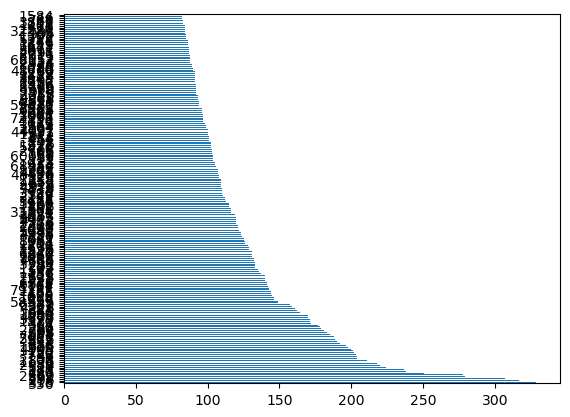

In [33]:
joined_movies_df['movie_id'].value_counts()[:200].plot(kind='barh')
plt.xticks=''

Here we can see "Forrest Gump (1994)" has significantly more reviews than any other movie within the data set, whilst many other movies only have a single review. This is a highly skewed dataset thant if left un addressed will cause the recamendations to be significantly bias.

### Data Processing
The data that has now been imported needs to be processed. The 'user_id's and 'movie_id's need to be converted into matrices

In [34]:
#We are going to create a unique list of every user within our dataset
User_list = user_df["user_id"].unique().tolist()
#Next we are going to enumerate each user within the list, this will show their user id and the oder in which it appears within the data set.
#This is important as we may have missing users, it is also data that is used to construct the matrix later on to give recamendations.
User_list_enumerated = {x: i for i, x in enumerate(User_list)}
#Now we map the enumerated data to the user_id's and add it to the user_enumerated column
user_df["user_enumerated"] = user_df["user_id"].map(User_list_enumerated)
user_df["user_enumerated"]

C:\Users\pereg\AppData\Local\Temp\ipykernel_22568\1877389342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df["user_enumerated"] = user_df["user_id"].map(User_list_enumerated)


0           0
1           0
2           0
3           0
4           0
         ... 
100831    609
100832    609
100833    609
100834    609
100835    609
Name: user_enumerated, Length: 100836, dtype: int64

Although the 'user_id's are not the only data we are using, we are aiming to include movies in the deep learning model as well. This means we need to enumerate the 'movie_id' so we can use them later in the process.

In [35]:
#We are going to create a unique list of every movie within our dataset
movie_list = user_df["movie_id"].unique().tolist()
#Next we are going to enumerate each user within the list, this will show their user id and the oder in which it appears within the data set.
#This is important as we may have missing users, it is also data that is used to construct the matrix later on to give recamendations.
movie_list_enumerated = {x: i for i, x in enumerate(movie_list)}
#Now we map the enumerated data to the user_id's and add it to the user_enumerated column
user_df["movies_enumerated"] = user_df["movie_id"].map(movie_list_enumerated)
user_df["movies_enumerated"]

0            0
1            1
2            2
3            3
4            4
          ... 
100831    3120
100832    2035
100833    3121
100834    1392
100835    2873
Name: movies_enumerated, Length: 100836, dtype: int64

In [36]:
num_users = len(User_list)
num_movies = len(movie_list)

user_df["rating"] = user_df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(user_df["rating"])
max_rating = max(user_df["rating"])

The next step is to split the data and create th training data

In [37]:
#Randomising the data samples
df = user_df.sample(frac=1, random_state=42)
df

,user_id,movie_id,rating,timestamps,user_enumerated,movies_enumerated
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


In [38]:
# Creating X values as "user_enumerated" & "movies_enumerated" in an array
x = df[["user_enumerated", "movies_enumerated"]].values
x

array([[ 431, 4730],
       [ 287,  474],
       [ 598, 2631],
       ...,
       [ 479, 2240],
       [   5,  712],
       [ 102, 2046]], dtype=int64)

In [39]:
#Normalizing the rating data between 0 and 1 makes the data easier to train

#Creating the min and max saves time when processing the data
min_rating = np.min(user_df["rating"])
max_rating = np.max(user_df["rating"])

#Normalizing the rating data
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([0.88888889, 0.55555556, 0.55555556, ..., 0.77777778, 0.55555556,
       1.        ])

In [40]:
# Splitting the data so 90% is used for training whilst 10% is used for results
train_indices = int(0.9 * df.shape[0])
train_indices

90752

In [41]:
#Creating the training data.
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [43]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
2836/2836 [==============================] - 13s 4ms/step - loss: 0.7602 - accuracy: 0.1244
Epoch 2/5
2836/2836 [==============================] - 12s 4ms/step - loss: 0.6384 - accuracy: 0.1304
Epoch 3/5
2836/2836 [==============================] - 11s 4ms/step - loss: 0.6343 - accuracy: 0.1313
Epoch 4/5
2836/2836 [==============================] - 14s 5ms/step - loss: 0.6355 - accuracy: 0.1312
Epoch 5/5
2836/2836 [==============================] - 16s 6ms/step - loss: 0.6362 - accuracy: 0.1313


In [44]:
# evaluate the keras model
accuracy = model.evaluate(x_val, y_val, verbose=0)
print(accuracy)

[0.6377627849578857, 0.128718763589859]


In [45]:
movie_df = joined_movies_df[["movie_id","title","genres"]]

# Let us get a user and see the top recommendations.
userId = 300
movies_watched_by_user = df[df.user_id == userId]
movies_not_watched = movie_df[~movie_df["movie_id"].isin(movies_watched_by_user.movie_id.values)]["movie_id"]



In [46]:
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie_list_enumerated.keys()))
)
movies_not_watched = [[movie_list_enumerated.get(x)] for x in movies_not_watched]
user_encoder = User_list_enumerated.get(userId)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()

303/303 [==============================] - 1s 3ms/step


In [47]:
rtest = np.unique(ratings)
rtest

array([0.66803616], dtype=float32)

In [48]:
top_ratings_indices = ratings.argsort()[-10:][::-1]
top_ratings_indices

array([9691, 3235, 3233, 3232, 3231, 3230, 3229, 3228, 3227, 3226],
      dtype=int64)

In [49]:
testing_rating = top_ratings_indices.tolist()
testing_rating

[9691, 3235, 3233, 3232, 3231, 3230, 3229, 3228, 3227, 3226]

In [50]:
movies_to_watch = movie_df[movie_df.index.isin(testing_rating)]
movies_to_watch

,movie_id,title,genres
3226,145,Bad Boys (1995),Action|Comedy|Crime|Drama|Thriller
3227,165,Die Hard: With a Vengeance (1995),Action|Crime|Thriller
3228,170,Hackers (1995),Action|Adventure|Crime|Thriller
3229,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
3230,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
3231,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3232,355,"Flintstones, The (1994)",Children|Comedy|Fantasy
3233,356,Forrest Gump (1994),Comedy|Drama|Romance|War
3235,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy
9691,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery
